In [33]:
from google.colab import drive
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence

from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.initializers import GlorotUniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import scipy.stats
from keras import backend as K

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [34]:
drive.mount('/content/drive', force_remount = True)
root_dir = '/content/drive/MyDrive/Toxic_comment_classification_Maggio_Monti/dataset/dataset_preprocessed/'


Mounted at /content/drive


In [35]:
from numpy import genfromtxt
x_train = genfromtxt(root_dir + 'x_train.csv', delimiter=',')
y_train = genfromtxt(root_dir + 'y_train.csv', delimiter=',')
x_train_augmented = genfromtxt(root_dir + 'x_train_augmented.csv', delimiter=',')
y_train_augmented = genfromtxt(root_dir + 'y_train_augmented.csv', delimiter=',')
x_train_augmented_balanced = genfromtxt(root_dir + 'x_train_augmented_balanced.csv', delimiter=',')
y_train_augmented_balanced = genfromtxt(root_dir + 'y_train_augmented_balanced.csv', delimiter=',')
x_test = genfromtxt(root_dir + 'x_test.csv', delimiter=',')
y_test = genfromtxt(root_dir + 'y_test.csv', delimiter=',')

In [36]:
print("Shape x_train_augmented:", x_train_augmented.shape)
print("Shape y_train_augmented:", y_train_augmented.shape)
print("Shape x_train_augmented_balanced:", x_train_augmented_balanced.shape)
print("Shape y_train_augmented_balanced:", y_train_augmented_balanced.shape)
print("Shape x_train:", x_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape x_test:", x_test.shape)
print("Shape y_test:", y_test.shape)

Shape x_train_augmented: (199131, 128)
Shape y_train_augmented: (199131, 6)
Shape x_train_augmented_balanced: (269571, 128)
Shape y_train_augmented_balanced: (269571, 6)
Shape x_train: (159571, 128)
Shape y_train: (159571, 6)
Shape x_test: (63978, 128)
Shape y_test: (63978, 6)


In [37]:
#  number of rows in incoming embedding vector
max_features = 20000 
# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 128 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

# initialize to same weights
initializer = GlorotUniform(42)

# early stopping procedure
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# dict for final plot
data_dict = {}
data_dict['category'] = ['Smaller Bidirectional',' Bigger bidirectional','Standard LSTM']
data_dict['lower'] = []
data_dict['mean'] = []
data_dict['upper'] = []

In [38]:
def plot_history(network_history, n_epochs):
    x_plot = list(range(1,n_epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.plot(x_plot, network_history.history['f1_m'])
    plt.plot(x_plot, network_history.history['val_f1_m'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.plot(x_plot, network_history.history['auc'])
    plt.plot(x_plot, network_history.history['val_auc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap=["#FFFFFF"], linewidths=1, linecolor="#000000")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('Predicted')
    axes.set_ylabel('Actual')
    axes.set_title("Confusion Matrix for the class - " + class_label)

# Basic training dataset LSTM

In [39]:
rnn_model = Sequential()

# add embedding layer 
rnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(SpatialDropout1D(0.3, seed=42))

# add bidirectional layer and pass in an LSTM()
rnn_model.add(Bidirectional(LSTM(42, return_sequences=True, kernel_initializer=initializer)))

# add normalization layer
rnn_model.add(BatchNormalization())

# add pooling layer 
rnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(Dropout(0.3, seed=42))

# add dense layer to produce an output dimension of 50 and using relu activation
rnn_model.add(Dense(18, activation='relu', kernel_initializer=initializer))

# finally add a dense layer
rnn_model.add(Dense(6, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy',
                  optimizer= Adam(0.0001),
                  metrics=['accuracy', f1_m, 'AUC'])

rnn_model.summary()


# Generate a print
print('------------------------------------------------------------------------')
history_basic = rnn_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=.2, verbose=1, callbacks=callback)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 128, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 84)           57456     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 84)           336       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 84)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 84)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)               

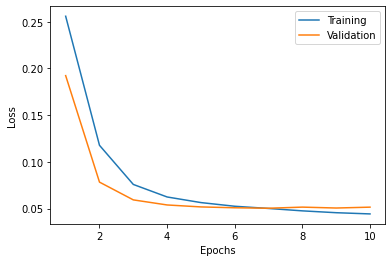

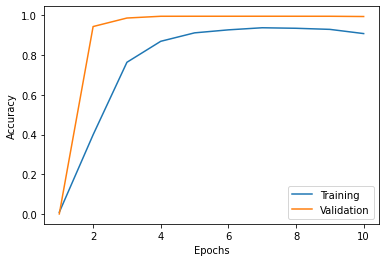

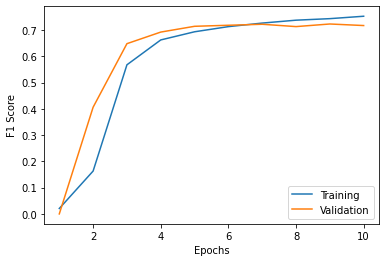

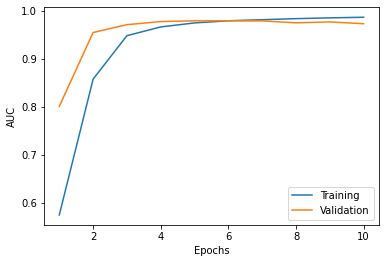

In [40]:
plot_history(history_basic, len(history_basic.history['val_loss']))

### Evaluation

In [41]:
y_pred = rnn_model.predict(x_test) > 0.5

In [42]:
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
conf_matrix

array([[[54472,  3416],
        [ 1278,  4812]],

       [[63610,     1],
        [  367,     0]],

       [[58848,  1439],
        [  974,  2717]],

       [[63767,     0],
        [  211,     0]],

       [[58537,  2014],
        [  995,  2432]],

       [[63263,     3],
        [  712,     0]]])

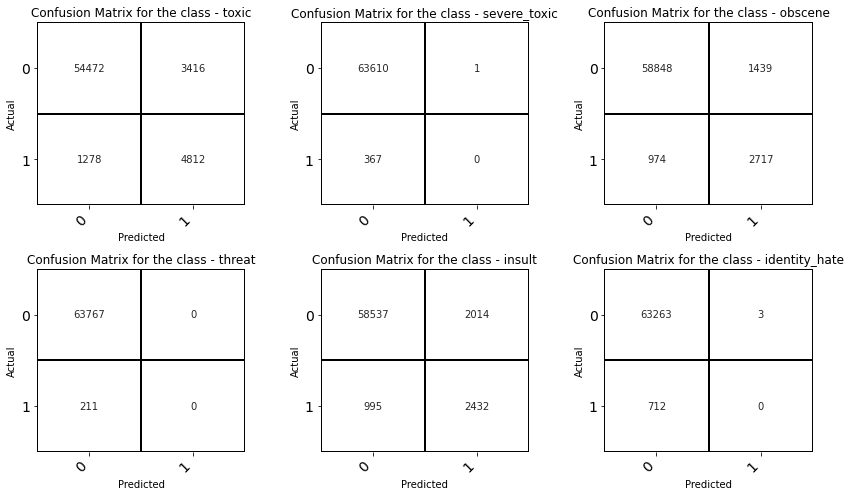

In [43]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()  

In [44]:
score = rnn_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print(classification_report(y_test, y_pred, zero_division=1))

Test loss: 0.07491285353899002
Test accuracy: 0.9975773096084595
              precision    recall  f1-score   support

           0       0.58      0.79      0.67      6090
           1       0.00      0.00      0.00       367
           2       0.65      0.74      0.69      3691
           3       1.00      0.00      0.00       211
           4       0.55      0.71      0.62      3427
           5       0.00      0.00      0.00       712

   micro avg       0.59      0.69      0.64     14498
   macro avg       0.46      0.37      0.33     14498
weighted avg       0.56      0.69      0.60     14498
 samples avg       0.94      0.97      0.91     14498



In [45]:
rnn_model.evaluate(x_test, y_test, return_dict=True)


2000/2000 [==============================] - 17s 8ms/step - loss: 0.0749 - accuracy: 0.9976 - f1_m: 0.5804 - auc: 0.9718


{'accuracy': 0.9975773096084595,
 'auc': 0.9718095660209656,
 'f1_m': 0.5803587436676025,
 'loss': 0.07491285353899002}

In [46]:
tf.keras.backend.clear_session()

# Augmented training dataset LSTM

In [47]:
rnn_model = Sequential()

# add embedding layer 
rnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(SpatialDropout1D(0.3, seed=42))

# add bidirectional layer and pass in an LSTM()
rnn_model.add(Bidirectional(LSTM(42, return_sequences=True, kernel_initializer=initializer)))

# add normalization layer
rnn_model.add(BatchNormalization())

# add pooling layer 
rnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(Dropout(0.3, seed=42))

# add dense layer to produce an output dimension of 50 and using relu activation
rnn_model.add(Dense(18, activation='relu', kernel_initializer=initializer))

# finally add a dense layer
rnn_model.add(Dense(6, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy',
                  optimizer= Adam(0.0001),
                  metrics=['accuracy', f1_m, 'AUC'])

rnn_model.summary()


# Generate a print
print('------------------------------------------------------------------------')
history_augmented = rnn_model.fit(x_train_augmented, y_train_augmented, batch_size=256, epochs=50, validation_split=.2, verbose=1, callbacks=callback)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 128)          2560000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 128, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 84)           57456     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 84)           336       
_________________________________________________________________
global_max_pooling1d (Global (None, 84)                0         
_________________________________________________________________
dropout (Dropout)            (None, 84)                0         
_________________________________________________________________
dense (Dense)                (None, 18)                1

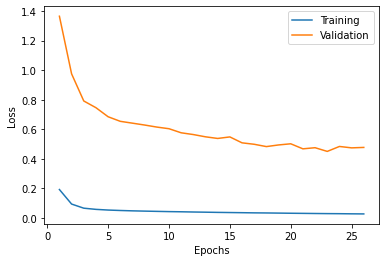

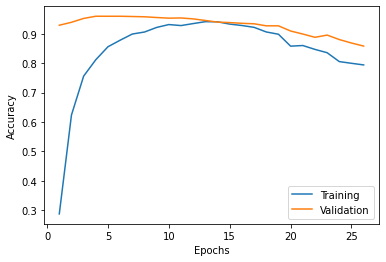

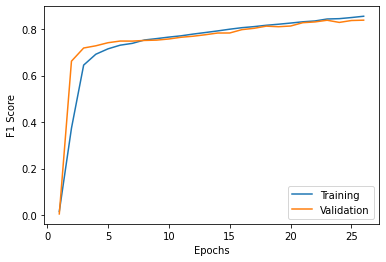

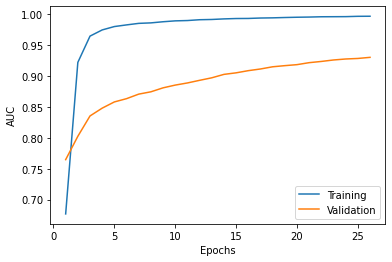

In [48]:
plot_history(history_augmented, len(history_augmented.history['val_loss']))

In [49]:
epoch =  np.argmin(history_augmented.history['val_loss'], axis=0)
history_augmented.history['val_f1_m'][epoch]

0.8380069136619568

## Evaluation

In [50]:
y_pred = rnn_model.predict(x_test) > 0.5

In [51]:
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
conf_matrix

array([[[53133,  4755],
        [  976,  5114]],

       [[63379,   232],
        [  216,   151]],

       [[58309,  1978],
        [  856,  2835]],

       [[63696,    71],
        [  138,    73]],

       [[58686,  1865],
        [ 1039,  2388]],

       [[63139,   127],
        [  494,   218]]])

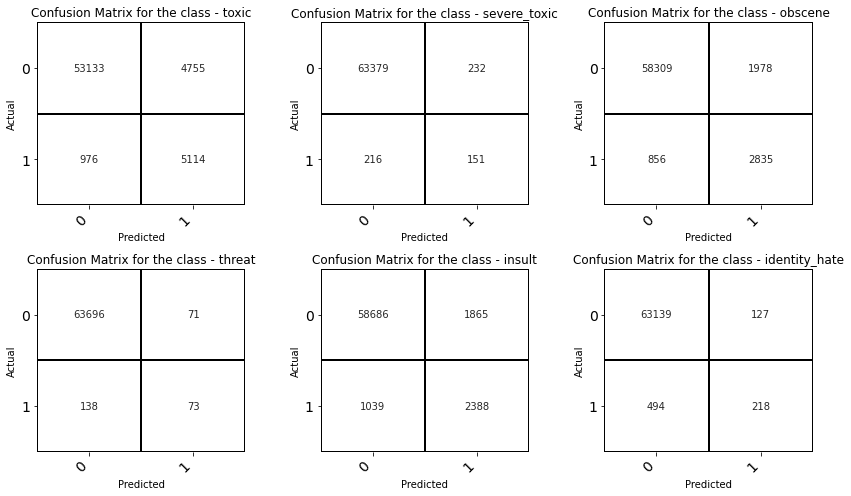

In [52]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()  

In [53]:
score = rnn_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print(classification_report(y_test, y_pred, zero_division=1))

Test loss: 0.09009727090597153
Test accuracy: 0.8777860999107361
              precision    recall  f1-score   support

           0       0.52      0.84      0.64      6090
           1       0.39      0.41      0.40       367
           2       0.59      0.77      0.67      3691
           3       0.51      0.35      0.41       211
           4       0.56      0.70      0.62      3427
           5       0.63      0.31      0.41       712

   micro avg       0.54      0.74      0.63     14498
   macro avg       0.53      0.56      0.53     14498
weighted avg       0.55      0.74      0.62     14498
 samples avg       0.92      0.97      0.90     14498



In [54]:
rnn_model.evaluate(x_test, y_test, return_dict=True)


2000/2000 [==============================] - 16s 8ms/step - loss: 0.0901 - accuracy: 0.8778 - f1_m: 0.5768 - auc: 0.9597


{'accuracy': 0.8777860999107361,
 'auc': 0.9597262740135193,
 'f1_m': 0.5768160223960876,
 'loss': 0.09009727090597153}

In [55]:
tf.keras.backend.clear_session()